# NIPS & ICML analysis

## Libraries & functions

In [1]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
import re
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
from textblob import TextBlob
from nltk.stem import PorterStemmer, WordNetLemmatizer
#import scholarly
import seaborn as sns
import nltk
import gensim
from gensim.utils import simple_preprocess
from spacy.lang.en.stop_words import STOP_WORDS
import pyLDAvis.gensim

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


C:\Users\Mike\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Preprocessing

def author_count(row):
    author_split = row.author.split('· ')
    author_count = len(author_split)
    return author_count

def lead_count(row):
    author_split = row.author.split('· ')
    lead_author = author_split[0]
    return lead_author

def lemmatize_stemming(text):
    lemtzer = WordNetLemmatizer()
    return lemtzer.lemmatize(text, pos='v')

def preprocess_list(text):
    result=[]
    for token in simple_preprocess(text) :
        if token not in STOP_WORDS:
            result.append(lemmatize_stemming(token))         
    return result
    
def sentiment_func(x):
    sentiment = TextBlob(x['abstract'])
    x['polarity'] = sentiment.polarity
    x['subjectivity'] = sentiment.subjectivity
    return x

# -----------------------------
# Create visuals

def create_wordcloud(text_series, cloud_title):
    wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
    wc.generate(' '.join(text_series))
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(cloud_title)
    plt.show()

def regplot_time(data, y_lim, categories, labels, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i in range(0,len(categories)):
        sns.regplot('year',categories[i], data, label = labels[i])
    
    plt.xlim(2007, 2019)
    plt.ylim(0, y_lim)
    ax.legend()
    ax.set(title = title,
           xlabel = "Conference year",
           ylabel = "Reference %")
    return plt, fig, ax

# -----------------------------
# Modelling

def compute_coherence_values(dictionary, corpus, texts, limit, passes = 1, decay = 0.5, start=2, step=3):
    coherence_values = []
    model_list = []
    decay_list = []
    topic_num_list = []
    for num_topics in range(start, limit, step):
        for decay in np.linspace(0.5, 1, num=5, endpoint=True):
            model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics, id2word=dictionary, decay = decay, passes=passes, workers=3)
            model_list.append(model)
            coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
            topic_num_list.append(num_topics)
            decay_list.append(decay)
    return model_list, coherence_values, decay_list, topic_num_list

## Import data

In [3]:
# Read in NeurIPS, remove superfluous info
df_nips = pd.read_csv('nips_schedule_all.csv')
df_nips['conference'] = 'NIPS'
df_nips = df_nips[df_nips.year != 2006]
df_nips = df_nips[df_nips.event_type != 'Placeholder']
df_nips = df_nips[df_nips.event_type != 'Break']

# Read in ICML, remove superfluous info
df_icml = pd.read_csv('icml_schedule.csv')
df_icml['conference'] = 'ICML'
df_icml = df_icml[df_icml.event_type != 'Break']

# Enrich with Kaggle dataset on NeruIPS paper
df_papers = pd.read_csv('papers.csv')
df_papers.title = df_papers.title.astype(str).map(lambda x: x.lower())
df_papers = df_papers.add_prefix("kaggle_")

In [4]:
# Combine NuerIPS and ICML
df = pd.concat([df_nips,df_icml],axis=0)
df.to_csv("research_data_combined.csv")

In [5]:
# Delete duplicate spoltlight sessions
print(df.shape)
df = df[df.event_type != 'Spotlight']
print(df.shape)

(12870, 6)
(11852, 6)


## Preprocess data

In [6]:
# Combine datasets and adjust apply basic processing
df.title = df.title.astype(str).map(lambda x: x.lower())
df.abstract = df.abstract.astype(str).apply(lambda x: re.sub('<p>','',x))
df.abstract = df.abstract.astype(str).apply(lambda x: re.sub('<div class="abstractContainer">','',x))
df.abstract = df.abstract.astype(str).apply(lambda x: re.sub('<\/div>','',x))
df.abstract = df.abstract.astype(str).apply(lambda x: re.sub('<\/p>','',x))
df.abstract = df.abstract.astype(str).apply(lambda x: re.sub('<\/div>','',x))
df.abstract = df.abstract.astype(str).apply(lambda x: re.sub('<br>','',x))
df.abstract = df.abstract.astype(str).apply(lambda x: re.sub('\n','',x))

#df = df.merge(df_papers, how='left', left_on='title', right_on ='kaggle_title')

In [7]:
df.author = df.author.astype(str)

df['author_new'] = df.author.str.split('· ')
df['author_count'] = df.apply(author_count, axis=1)
df['lead_author'] = df.apply(lead_count, axis=1)

In [8]:
# Remove common vocabulary across abstracts and titles

df['abstract_adj'] = df.abstract.astype(str).map(lambda x: x.lower())
df['title_adj'] = df.title.astype(str).map(lambda x: x.lower())

mapping = [ ('machine', ''), ('learning', ''), ('data', ''), ('science', ''), 
           ('ml', ''), ('model', ''), ('method', ''), ('application',''), ('program',''),
          ('problem',''), ('algorithm',''), ('analysis',''), ('technique',''),
          ('propose',''),('process',''),('provide',''),('provide',''),
          ('workshop',''), ('system',''), ('approaches',''), ('computational',''),
          ('using',''), ('via',''),('session',''), ('use',''), ('et al',''),
          ('set',''), ('show',''),('based',''),('new',''), ('result',''), ('task', '')
          ]

for k, v in mapping:
    df['abstract_adj'] = df['abstract_adj'].str.replace(k, v)
    df['title_adj'] = df['title_adj'].str.replace(k, v)
#    df['kaggle_paper_text'] = df['kaggle_paper_text'].str.replace(k, v)

In [9]:
# Lemamatize and remove stop words from abstracts

df['title_plus_abstract'] = df['title_adj'] + df['abstract_adj'] 
df['title_list'] = df['title_adj'].apply(lambda x: preprocess_list(x))
df['abstract_list'] = df['abstract_adj'].apply(lambda x: preprocess_list(x))
df['title_plus_abstract_list'] = df['title_plus_abstract'].apply(lambda x: preprocess_list(x))
df['abstract_string'] = df['abstract_list'].apply(lambda x: " ".join(x))
df['title_string'] = df['title_list'].apply(lambda x: " ".join(x))
df['title_plus_abstract_string'] = df['title_plus_abstract_list'].apply(lambda x: " ".join(x))

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [10]:
# Add sentiment analysis

df = df.apply(sentiment_func, axis=1)

### Basic EDA

In [11]:
df.groupby(['conference','year','event_type']).count()

abstract  author  title  \
conference year event_type                                                
ICML       2017 Invited Talk                           4       4      4   
                Poster                               434     434    434   
                Talk                                 435     435    435   
                Tutorial                               9       9      9   
                Workshop                              22      22     22   
           2018 Invited Talk                           4       4      4   
                Oral                                 621     621    621   
                Poster                               621     621    621   
                Session                                3       3      3   
                Talk                                   1       1      1   
                Tutorial                               9       9      9   
                Workshop                              75      75     75   
           2019 Invited Talk                           7       7      7   
                Oral                                 773     773    773   
                Poster                               773     773    773   
                Talk                                   1       1      1   
                Tutorial                              11      11     11   
                Workshop                              31      31     31   
NIPS       2007 Demonstration                         17      17     17   
                Invited Talk                           6       6      6   
                Oral                                  26      26     26   
                Poster                               217     217    217   
                Session                               21      21     21   
                Tutorial                               6       6      6   
                Workshop                              26      26     26   
           2008 Demonstration                         14      14     14   
                Invited Talk                           5       5      5   
                Mini Symposium                         5       5      5   
                Oral                                  28      28     28   
                Poster                               250     250    250   
                Session                               23      23     23   
                Tutorial                               6       6      6   
                Workshop                              26      26     26   
           2009 Demonstration                         16      16     16   
                Invited Talk                           7       7      7   
                Mini Symposium                         5       5      5   
                Oral                                  22      22     22   
                Poster                               262     262    262   
                Session                               22      22     22   
                Tutorial                               6       6      6   
           2010 Demonstration                         12      12     12   
                Invited Talk                           4       4      4   
                Oral                                  20      20     20   
                Posner Lecture                         2       2      2   
                Poster                               292     292    292   
                Session                               37      37     37   
                Talk                                   6       6      6   
                Tutorial                               6       6      6   
                Workshop                              28      28     28   
           2011 Demonstration                          8       8      8   
                Invited Talk                           4       4      4   
                Oral                                  20      20     20  

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

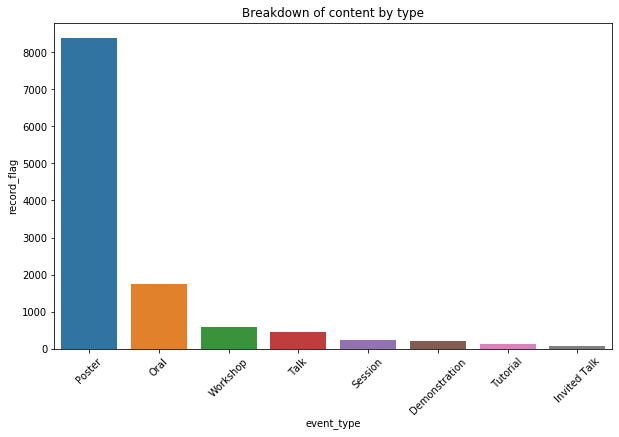

In [12]:
df['record_flag'] = 1 # add count flag for all rows
summary_events = df.groupby('event_type').record_flag.count()[df.groupby('event_type').record_flag.count()>50].sort_values(ascending = False)
summary_events_df = pd.DataFrame(summary_events).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title = "Breakdown of content by type",
       ylabel = "Count per category")
sns.barplot(x = 'event_type', y = 'record_flag', data=summary_events_df)
plt.xticks(rotation=45)

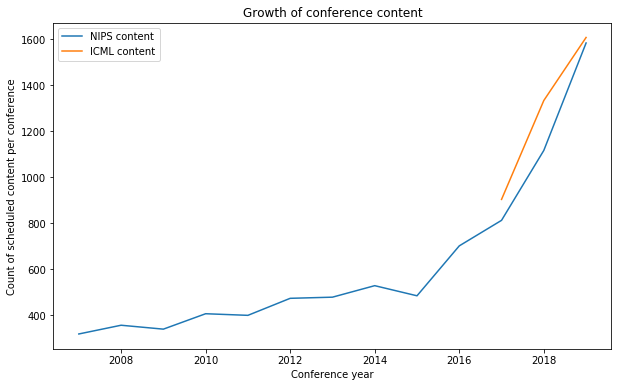

In [13]:
# Plot conference content over time

high_level_nips = df[df.conference == 'NIPS'].groupby(['year']).record_flag.count()
high_level_icml = df[df.conference == 'ICML'].groupby(['year']).record_flag.count()

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title = "Growth of conference content",
       xlabel = "Conference year",
       ylabel = "Count of scheduled content per conference")
plt.plot(high_level_nips, label = 'NIPS content')
plt.plot(high_level_icml, label = 'ICML content')
plt.legend()

## NLP understanding

### Wordclouds

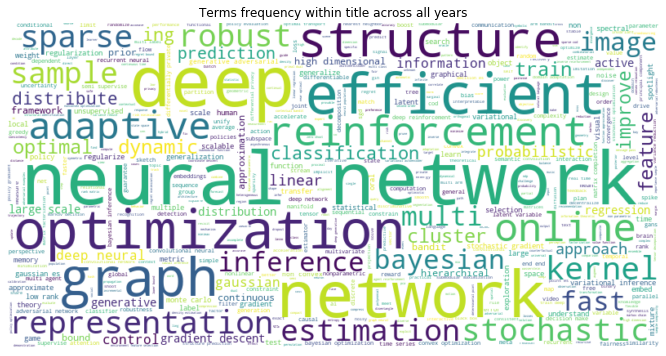

In [14]:
create_wordcloud(df['title_string'], "Terms frequency within title across all years")

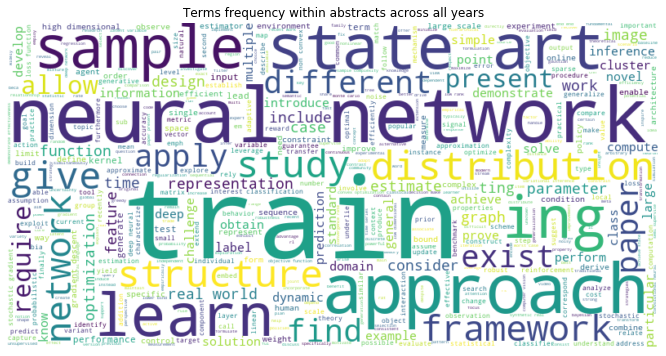

In [15]:
create_wordcloud(df['abstract_string'], "Terms frequency within abstracts across all years")

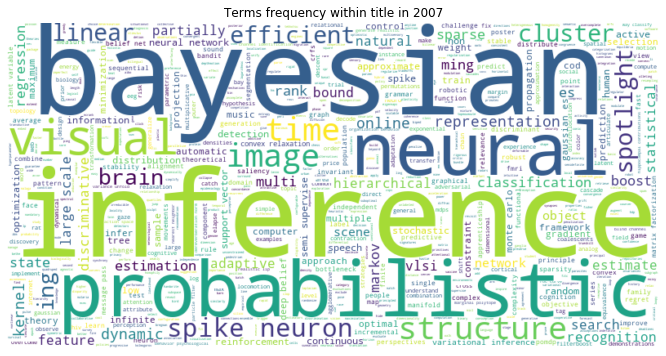

In [16]:
create_wordcloud(df[df.year == 2007].title_string, "Terms frequency within title in 2007")

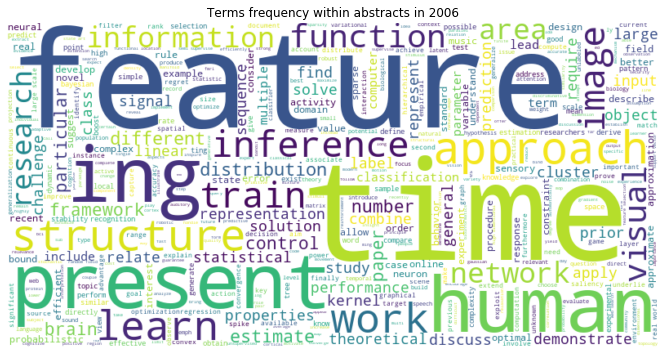

In [17]:
create_wordcloud(df[df.year == 2007].abstract_string, "Terms frequency within abstracts in 2006")

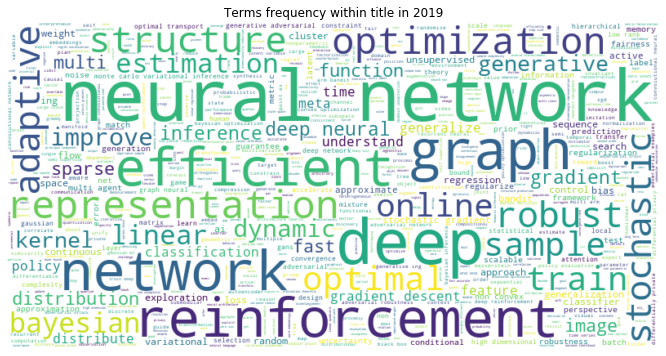

In [18]:
create_wordcloud(df[df.year == 2019].title_string, "Terms frequency within title in 2019")

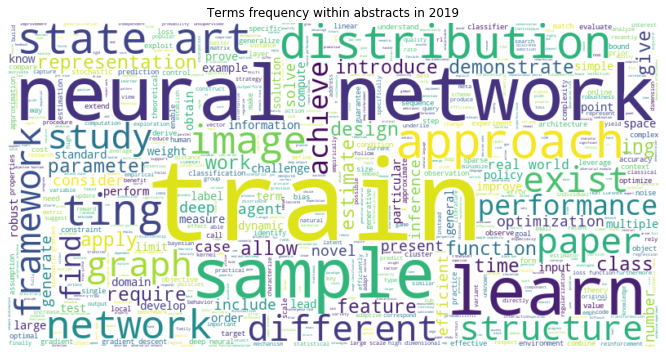

In [19]:
create_wordcloud(df[df.year == 2019].abstract_string, "Terms frequency within abstracts in 2019")

### Manual trend  analysis

In [20]:
# Create list to check for in abstract, grouped by type

# Specific technique
general_NN_list = ['neural', 'network']
GAN_list = ['gan', 'generative']
CNN_list = ['cnn','dcn','dcign','convolutional', 'convnet', 'convolutions', 'convolution', 'deconvolutional']
RNN_list = ['rnn', 'recurrent','lstm', 'gru']
tree_list = ['tree','forest','gbm','xgboost','bagging','boosted','boosting']
reinforcement_list = ['reinforcement','agent','policy','environment''markov', 'mdp', 'bandit']
SVM_list = ['svm', 'vector']
monte_carlo_list = ['mc','monte', 'carlo']
gaussian_list = ['gaussian']
deep_list = ['deep', 'dnn' ]
bayes_list = ['bayes', 'bayesian']

# Applications
vision_list = ['vision', 'image', 'video', 'photo', 'picture', 'optical', 'mnist', 'cifar', 'svhn', 'celeba']
nlp_list = ['nlp', 'language', 'translation', 'linguistic','speech', 'translate', 'semantic','translation','voice']
robot_list = ['robotics','robot','droid','drone']
game_list = ['game','videogame','boardgame','play','chess','atari','hanabi']
bio_list = ['biology', 'biological', 'genome', 'genomics', 'bioinformatics', 'protein', 'medicine', 'oncology']
ethics_list = ['ethics','fair','fairness','secure','private','privacy','security', 'ethical', 'explainable', 'explainability']

# ML standard datasets
dataset_names = ["MNIST", "CIFAR", "SVHN", "PASCAL", "KITTI", "TFD", "SensIT", "Connect4",
                 "adult", "credit", "kr-vs-kp", "promoters", "votes", "UCI", "digg", "HepTH",
                 "citeseer", "MovieLens", "RocketFuel", "tweet", "twitter", "bAbI", "TreeBank",
                 "SARCOS", "NORB", "TIMIT", "ImageNet", "Street View", "VGG", "Caltech-101",
                 "FM-IQA", "AP News", "newsgroups", "diabetes", "HES", "prostate", "MS COCO",
                 "Toronto Face", "glaucoma", "Alzheimer’s", "news20", "scleroderma",
                 "puzzle", "MADELON", "ENRON", "WIPO", "reuters", "CelebA", "Text8",
                 "Protein", "STL10"]

# Combine in to list of lists
specific_LL = [general_NN_list, GAN_list, CNN_list, RNN_list, tree_list, reinforcement_list, SVM_list, monte_carlo_list, gaussian_list, deep_list, bayes_list]
applications_LL = [vision_list, nlp_list, robot_list, game_list, bio_list, ethics_list]

#Create True/False columns for presence of word in defined lists
for i in range(0,len(specific_LL)):
    df[str(specific_LL[i][0])+"_specific_flag"] = df["title_plus_abstract_string"].str.contains('|'.join(specific_LL[i]))

for i in range(0,len(applications_LL)):
    df[str(applications_LL[i][0])+"_application_flag"] = df["title_plus_abstract_string"].str.contains('|'.join(applications_LL[i]))

for i in range(0,len(dataset_names)):
    df[str(dataset_names[i])+"_dataset_flag"] = df["abstract"].str.contains(dataset_names[i])

In [21]:
#df.to_csv("ml_research_processed.csv")

### Summary trends

In [22]:
summary_trends = df.groupby('year').sum()
summary_trends = summary_trends.reset_index() 

for columns in summary_trends:
    summary_trends[str(columns) + '_perc'] = 100 * summary_trends[columns]/summary_trends.record_flag
summary_trends

,year,author_count,polarity,subjectivity,record_flag,neural_specific_flag,gan_specific_flag,cnn_specific_flag,rnn_specific_flag,tree_specific_flag,reinforcement_specific_flag,svm_specific_flag,mc_specific_flag,gaussian_specific_flag,deep_specific_flag,bayes_specific_flag,vision_application_flag,nlp_application_flag,robotics_application_flag,game_application_flag,biology_application_flag,ethics_application_flag,MNIST_dataset_flag,CIFAR_dataset_flag,SVHN_dataset_flag,PASCAL_dataset_flag,KITTI_dataset_flag,TFD_dataset_flag,SensIT_dataset_flag,Connect4_dataset_flag,adult_dataset_flag,credit_dataset_flag,kr-vs-kp_dataset_flag,promoters_dataset_flag,votes_dataset_flag,UCI_dataset_flag,digg_dataset_flag,HepTH_dataset_flag,citeseer_dataset_flag,MovieLens_dataset_flag,RocketFuel_dataset_flag,tweet_dataset_flag,twitter_dataset_flag,bAbI_dataset_flag,TreeBank_dataset_flag,SARCOS_dataset_flag,NORB_dataset_flag,TIMIT_dataset_flag,ImageNet_dataset_flag,Street View_dataset_flag,VGG_dataset_flag,Caltech-101_dataset_flag,FM-IQA_dataset_flag,AP News_dataset_flag,newsgroups_dataset_flag,diabetes_dataset_flag,HES_dataset_flag,prostate_dataset_flag,MS COCO_dataset_flag,Toronto Face_dataset_flag,glaucoma_dataset_flag,Alzheimer’s_dataset_flag,news20_dataset_flag,scleroderma_dataset_flag,puzzle_dataset_flag,MADELON_dataset_flag,ENRON_dataset_flag,WIPO_dataset_flag,reuters_dataset_flag,CelebA_dataset_flag,Text8_dataset_flag,Protein_dataset_flag,STL10_dataset_flag,year_perc,author_count_perc,polarity_perc,subjectivity_perc,record_flag_perc,neural_specific_flag_perc,gan_specific_flag_perc,cnn_specific_flag_perc,rnn_specific_flag_perc,tree_specific_flag_perc,reinforcement_specific_flag_perc,svm_specific_flag_perc,mc_specific_flag_perc,gaussian_specific_flag_perc,deep_specific_flag_perc,bayes_specific_flag_perc,vision_application_flag_perc,nlp_application_flag_perc,robotics_application_flag_perc,game_application_flag_perc,biology_application_flag_perc,ethics_application_flag_perc,MNIST_dataset_flag_perc,CIFAR_dataset_flag_perc,SVHN_dataset_flag_perc,PASCAL_dataset_flag_perc,KITTI_dataset_flag_perc,TFD_dataset_flag_perc,SensIT_dataset_flag_perc,Connect4_dataset_flag_perc,adult_dataset_flag_perc,credit_dataset_flag_perc,kr-vs-kp_dataset_flag_perc,promoters_dataset_flag_perc,votes_dataset_flag_perc,UCI_dataset_flag_perc,digg_dataset_flag_perc,HepTH_dataset_flag_perc,citeseer_dataset_flag_perc,MovieLens_dataset_flag_perc,RocketFuel_dataset_flag_perc,tweet_dataset_flag_perc,twitter_dataset_flag_perc,bAbI_dataset_flag_perc,TreeBank_dataset_flag_perc,SARCOS_dataset_flag_perc,NORB_dataset_flag_perc,TIMIT_dataset_flag_perc,ImageNet_dataset_flag_perc,Street View_dataset_flag_perc,VGG_dataset_flag_perc,Caltech-101_dataset_flag_perc,FM-IQA_dataset_flag_perc,AP News_dataset_flag_perc,newsgroups_dataset_flag_perc,diabetes_dataset_flag_perc,HES_dataset_flag_perc,prostate_dataset_flag_perc,MS COCO_dataset_flag_perc,Toronto Face_dataset_flag_perc,glaucoma_dataset_flag_perc,Alzheimer’s_dataset_flag_perc,news20_dataset_flag_perc,scleroderma_dataset_flag_perc,puzzle_dataset_flag_perc,MADELON_dataset_flag_perc,ENRON_dataset_flag_perc,WIPO_dataset_flag_perc,reuters_dataset_flag_perc,CelebA_dataset_flag_perc,Text8_dataset_flag_perc,Protein_dataset_flag_perc,STL10_dataset_flag_perc
0,2007,887,15.082057,70.431090,319,42.0,23.0,0.0,3.0,14.0,26.0,15.0,10.0,10.0,9.0,25.0,38.0,21.0,8.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,629.153605,278.056426,4.727918,22.078711,100.0,13.166144,7.210031,0.000000,0.940439,4.388715,8.150470,4.702194,3.134796,3.134796,2.821317,7.836991,11.912226,6.583072,2.507837,5.015674,5.015674,1.567398,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.313480,0.313480,0.0,0.0,0.313480,0.313480,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

(<module 'matplotlib.pyplot' from 'C:\\Users\\Mike\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 <Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x24b7b388148>)

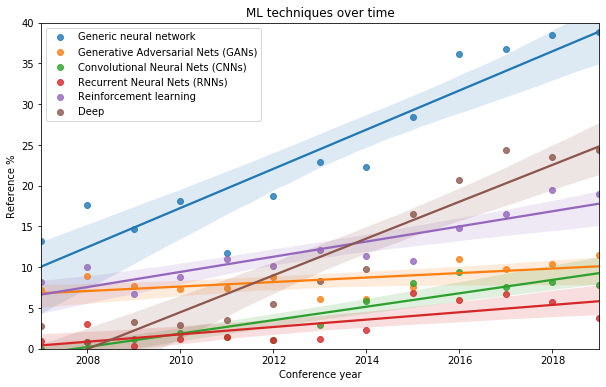

In [23]:
categories = ['neural_specific_flag_perc','gan_specific_flag_perc','cnn_specific_flag_perc','rnn_specific_flag_perc','reinforcement_specific_flag_perc','deep_specific_flag_perc']
labels = ['Generic neural network','Generative Adversarial Nets (GANs)', 'Convolutional Neural Nets (CNNs)', 'Recurrent Neural Nets (RNNs)', 'Reinforcement learning', 'Deep'] 
regplot_time(summary_trends, 40, categories, labels, "ML techniques over time")

(<module 'matplotlib.pyplot' from 'C:\\Users\\Mike\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 <Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x24b7b3da188>)

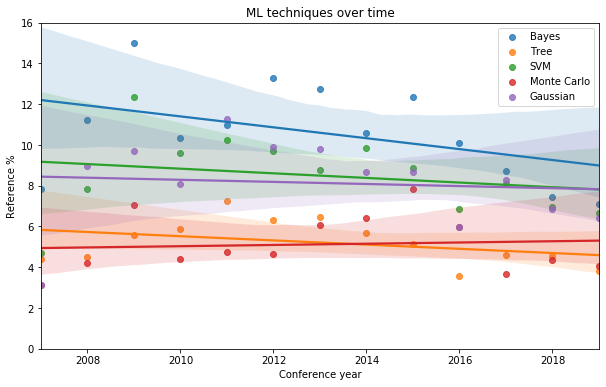

In [24]:
categories = ['bayes_specific_flag_perc','tree_specific_flag_perc','svm_specific_flag_perc','mc_specific_flag_perc','gaussian_specific_flag_perc']
labels = ['Bayes', 'Tree', 'SVM','Monte Carlo', 'Gaussian'] 
regplot_time(summary_trends, 16, categories, labels, "ML techniques over time")

(<module 'matplotlib.pyplot' from 'C:\\Users\\Mike\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 <Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x24b0825b208>)

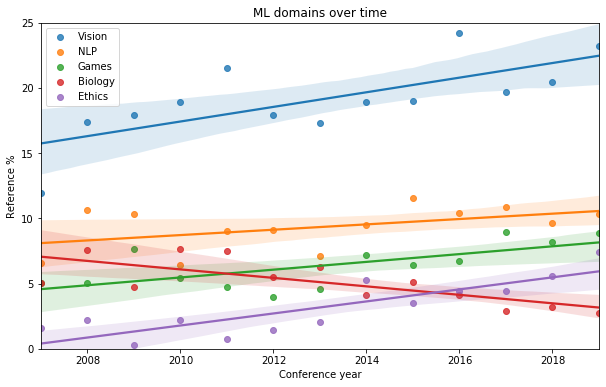

In [25]:
categories = ['vision_application_flag_perc','nlp_application_flag_perc', 'game_application_flag_perc','biology_application_flag_perc', 'ethics_application_flag_perc']
labels = ['Vision', 'NLP', 'Games', 'Biology', 'Ethics'] 
regplot_time(summary_trends, 25, categories, labels, "ML domains over time")

(<module 'matplotlib.pyplot' from 'C:\\Users\\Mike\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 <Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x24b7ae7a0c8>)

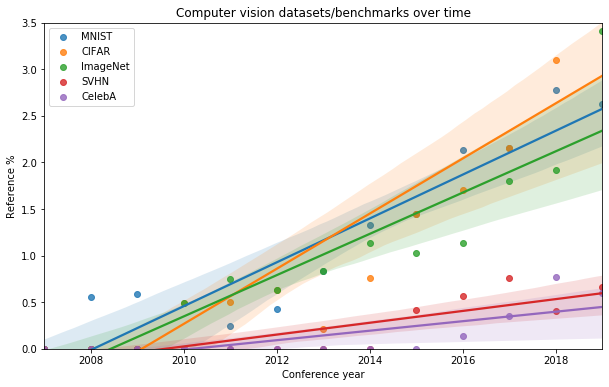

In [26]:
categories = ['MNIST_dataset_flag_perc','CIFAR_dataset_flag_perc','ImageNet_dataset_flag_perc','SVHN_dataset_flag_perc','CelebA_dataset_flag_perc',]
labels = ['MNIST', 'CIFAR', 'ImageNet', 'SVHN', 'CelebA'] 
regplot_time(summary_trends, 3.5, categories, labels, "Computer vision datasets/benchmarks over time")

### Author analysis

In [27]:
df.author_count.agg(['mean','median'])

mean      3.507172
median    3.000000
Name: author_count, dtype: float64

(1, 10)

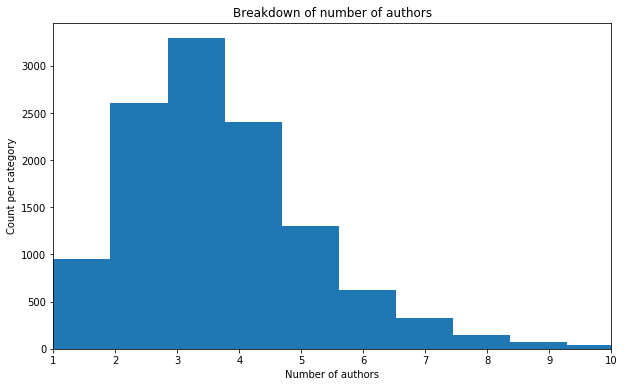

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title = "Breakdown of number of authors",
       xlabel = "Number of authors",
       ylabel = "Count per category")

n, bins, patches = plt.hist(x=df.author_count, bins = 25)
plt.xlim(1,10)

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title = "Citation in ML research",
       ylabel = "Count of citations, 1000s")
plt.plot(citations_df.citations/1000)

### Sentiment analysis

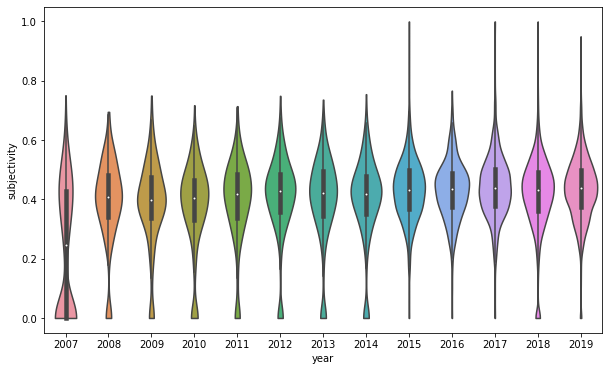

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.violinplot(x = "year", y="subjectivity", data=df, cut=0)

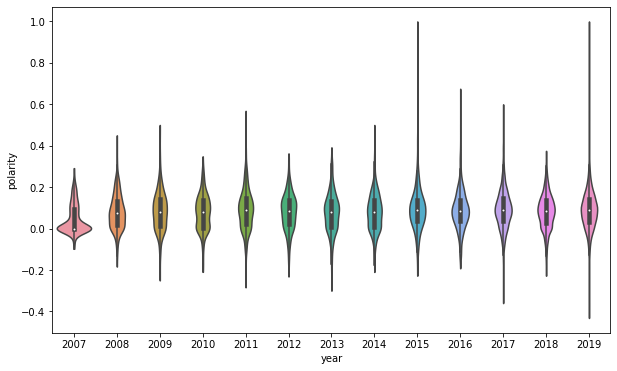

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.violinplot(x = "year", y="polarity", data=df, cut=0)

### LDA - abstract analysis

In [31]:
processed_docs = []
for doc in df.title_plus_abstract_list:
    processed_docs.append(doc)

dictionary = gensim.corpora.Dictionary(processed_docs)
# OPTIONAL
dictionary.filter_extremes(no_below=15, no_above=0.05)#, keep_n=10000)
print(len(dictionary.keys()))

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
%time lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=1, decay=0.6, workers=3)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}\n'.format(idx, topic))

3653
Wall time: 21.4 s
Topic: 0 Word: 0.006*"tree" + 0.006*"visual" + 0.005*"signal" + 0.004*"view" + 0.003*"plan" + 0.003*"distribute" + 0.003*"partition" + 0.003*"reason" + 0.003*"change" + 0.003*"em"

Topic: 1 Word: 0.006*"agent" + 0.005*"rl" + 0.004*"selection" + 0.004*"bandit" + 0.004*"regret" + 0.004*"reward" + 0.003*"agents" + 0.003*"behavior" + 0.003*"update" + 0.003*"memory"

Topic: 2 Word: 0.004*"tree" + 0.003*"dynamics" + 0.003*"sketch" + 0.003*"markov" + 0.003*"spectral" + 0.003*"community" + 0.003*"discrete" + 0.003*"domains" + 0.002*"variance" + 0.002*"bias"

Topic: 3 Word: 0.005*"memory" + 0.005*"em" + 0.004*"attention" + 0.004*"spike" + 0.003*"run" + 0.003*"computer" + 0.003*"end" + 0.003*"dynamics" + 0.003*"epsilon" + 0.002*"hierarchical"

Topic: 4 Word: 0.005*"reward" + 0.005*"end" + 0.003*"tensor" + 0.003*"discrete" + 0.003*"privacy" + 0.003*"architecture" + 0.003*"embed" + 0.003*"risk" + 0.003*"global" + 0.003*"regularization"

Topic: 5 Word: 0.007*"regret" + 0.005*

In [32]:
# Tune clustering parameters and save results

#%time model_list, coherence_values, decay_values, topic_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=processed_docs, start=2, limit=25, passes=4, step=1)
#results = pd.DataFrame([topic_values, decay_values, coherence_values]).T
#results.columns = ['num_topics','alpha','coherence']
#results.to_csv(dest/'tuning_results')

In [33]:
#results_trend = results.pivot(index='num_topics', columns='alpha', values='coherence')
#results_trend.plot()
#plt.ylabel("Coherence score")
#plt.show()

#### Take optimal number of topics

In [34]:
#%time lda_model_final = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=10, decay=0.5, random_state=1)
#shows RL and fairness

%time lda_model_final = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=20, decay=0.75, random_state=1)
gensim.models.LdaMulticore
lda_model_final.save('lda.model')
cm_final = gensim.models.CoherenceModel(model=lda_model_final, texts = processed_docs, corpus=bow_corpus, coherence='c_v')
coherence = cm_final.get_coherence()
print("Coherence = ",coherence)

Wall time: 3min 52s
Coherence =  0.3922746892759474


In [35]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_final, bow_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.206360  0.037276       1        1  15.147837
9      0.135856 -0.050635       2        1  13.419576
8     -0.150298 -0.030438       3        1  12.530169
5     -0.041623 -0.060863       4        1   9.748523
6      0.003811 -0.098840       5        1   9.144114
1      0.034420 -0.066387       6        1   8.989451
0     -0.047696 -0.058112       7        1   8.661641
3      0.059781  0.170712       8        1   8.219110
2     -0.129066  0.121406       9        1   8.072725
7     -0.071545  0.035882      10        1   6.066847, topic_info=     Category         Freq       Term        Total  loglift  logprob
1393  Default  1261.000000     regret  1261.000000  30.0000  30.0000
79    Default  1002.000000      agent  1002.000000  29.0000  29.0000
1312  Default  1066.000000     reward  1066.000000  28.0000  28.0000
1458  Default   704.000000         rl   704.000000  27.0000  27.0000
1380  Default   677.000000        arm   677.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
945   Topic10   143.756454       emph   602.822693   1.3688  -5.3642
1105  Topic10   114.023193  theoretic   301.650391   1.8295  -5.5960
428   Topic10   116.872902   instance   788.967957   0.8927  -5.5713
1545  Topic10   114.892899   distance   896.853394   0.7474  -5.5884
417   Topic10   111.628677   variable   756.605774   0.8887  -5.6172

[654 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2452      5  0.061127     abstain
2452     10  0.916908     abstain
3085      1  0.979695    academia
3129      1  0.973341    academic
1415      1  0.074453  accelerate
...     ...       ...         ...
263       6  0.025923       years
263       7  0.044070       years
263       8  0.025923       years
263       9  0.025923       years
263      10  0.036293       years

[3600 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 9, 6, 7, 2, 1, 4, 3, 8])

In [36]:
results = [dict(lda_model[x]) for x in bow_corpus]
df_results = pd.DataFrame(results)
df_results = df_results.add_prefix('topic_')

df.reset_index(inplace=True)
df_output = pd.concat([df,df_results],axis=1)

df_output.head()

,index,abstract,author,event_type,title,year,conference,author_new,author_count,lead_author,abstract_adj,title_adj,title_plus_abstract,title_list,abstract_list,title_plus_abstract_list,abstract_string,title_string,title_plus_abstract_string,polarity,subjectivity,record_flag,neural_specific_flag,gan_specific_flag,cnn_specific_flag,rnn_specific_flag,tree_specific_flag,reinforcement_specific_flag,svm_specific_flag,mc_specific_flag,gaussian_specific_flag,deep_specific_flag,bayes_specific_flag,vision_application_flag,nlp_application_flag,robotics_application_flag,game_application_flag,biology_application_flag,ethics_application_flag,MNIST_dataset_flag,CIFAR_dataset_flag,SVHN_dataset_flag,PASCAL_dataset_flag,KITTI_dataset_flag,TFD_dataset_flag,SensIT_dataset_flag,Connect4_dataset_flag,adult_dataset_flag,credit_dataset_flag,kr-vs-kp_dataset_flag,promoters_dataset_flag,votes_dataset_flag,UCI_dataset_flag,digg_dataset_flag,HepTH_dataset_flag,citeseer_dataset_flag,MovieLens_dataset_flag,RocketFuel_dataset_flag,tweet_dataset_flag,twitter_dataset_flag,bAbI_dataset_flag,TreeBank_dataset_flag,SARCOS_dataset_flag,NORB_dataset_flag,TIMIT_dataset_flag,ImageNet_dataset_flag,Street View_dataset_flag,VGG_dataset_flag,Caltech-101_dataset_flag,FM-IQA_dataset_flag,AP News_dataset_flag,newsgroups_dataset_flag,diabetes_dataset_flag,HES_dataset_flag,prostate_dataset_flag,MS COCO_dataset_flag,Toronto Face_dataset_flag,glaucoma_dataset_flag,Alzheimer’s_dataset_flag,news20_dataset_flag,scleroderma_dataset_flag,puzzle_dataset_flag,MADELON_dataset_flag,ENRON_dataset_flag,WIPO_dataset_flag,reuters_dataset_flag,CelebA_dataset_flag,Text8_dataset_flag,Protein_dataset_flag,STL10_dataset_flag,topic_2,topic_9,topic_6,topic_8,topic_0,topic_1,topic_3,topic_4,topic_5,topic_7
0,0,"Update Dec 2. For the latest, click the link a...",nan,AffinityWorkshop,black in ai (bai) affinity workshop,2019,NIPS,[nan],1,nan,"update dec 2. for the latest, click the link a...",black in ai (bai) affinity,black in ai (bai) affinity update dec 2. for t...,"[black, ai, bai, affinity]","[update, dec, latest, click, link, time, event...","[black, ai, bai, affinity, update, dec, latest...",update dec latest click link time event speake...,black ai bai affinity,black ai bai affinity update dec latest click ...,0.250000,0.500000,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.042106,0.947225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Despite the exploding interest in graph neural...,Aleksandar Bojchevski · Stephan Günnemann,Poster,certifiable robustness to graph perturbations,2019,NIPS,"[Aleksandar Bojchevski , Stephan Günnemann]",2,Aleksandar Bojchevski,despite the exploding interest in graph neural...,certifiable robustness to graph perturbations,certifiable robustness to graph perturbationsd...,"[certifiable, robustness, graph, perturbations]","[despite, explode, interest, graph, neural, ne...","[certifiable, robustness, graph, explode, inte...",despite explode interest graph neural network ...,certifiable robustness graph perturbations,certifiable robustness graph explode interest ...,0.112917,0.463333,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,0.969992,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,"Adversarial training, in which a network is tr...",Ali Shafahi · Mahyar Najibi · Mohammad 

In [37]:
topic_trends_sum = df_output.groupby('year').sum()[['topic_0','topic_1','topic_2','topic_3','topic_4','topic_6',
                                                 'topic_6','topic_7','topic_8','topic_8','topic_9']]
topic_trends_sum

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_6,topic_6,topic_7,topic_8,topic_8,topic_9
year,,,,,,,,,,,
2007,51.779256,38.626889,28.677543,31.589486,27.197353,20.998580,20.998580,30.732563,27.621504,27.621504,30.637329
2008,40.865937,35.524931,41.660033,23.778246,37.056781,32.054839,32.054839,29.821202,31.530759,31.530759,40.905636
2009,64.850358,36.403663,27.455547,23.484632,28.301403,38.059439,38.059439,25.019035,33.174309,33.174309,34.819449
2010,62.333881,42.921239,37.330427,34.526981,53.664268,33.041587,33.041587,27.769366,33.928379,33.928379,41.653815
2011,54.866970,50.099157,36.162992,33.261604,46.330302,42.801626,42.801626,18.840157,28.816527,28.816527,41.083743
2012,55.758223,46.940997,48.811779,34.555365,63.309128,55.999567,55.999567,43.916386,30.954360,30.954360,44.299243
2013,50.818169,42.372625,53.015825,37.174587,65.450698,61.109008,61.109008,31.527252,32.731728,32.731728,47.414209
2014,63.164769,50.024219,49.788884,40.642456,82.112066,57.986166,57.986166,33.337907,39.942864,39.942864,51.924047
2015,55.500698,34.108397,55.864268,37.356839,61.724287,63.271898,63.271898,32.115205,39.738642,39.738642,45.623912


No handles with labels found to put in legend.


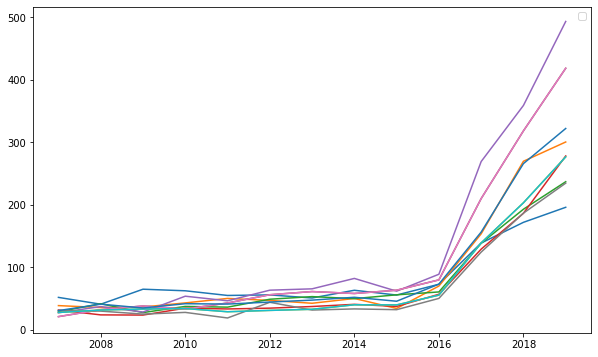

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(topic_trends_sum)
plt.legend()

In [39]:
topic_trends_av = df_output.groupby('year').mean()[['topic_0','topic_1','topic_2','topic_3','topic_4',
                                                 'topic_5','topic_6','topic_7','topic_8','topic_9']].reset_index()
topic_trends_av

,year,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,2007,0.245399,0.205462,0.160210,0.178472,0.155413,0.159466,0.117970,0.169793,0.161529,0.168337
1,2008,0.389199,0.403692,0.443192,0.297228,0.451912,0.462188,0.395739,0.372765,0.379889,0.417404
2,2009,0.487597,0.472775,0.351994,0.335495,0.393075,0.318582,0.392365,0.333587,0.376981,0.378472
3,2010,0.389587,0.451803,0.348882,0.348757,0.443506,0.313313,0.330416,0.319188,0.326234,0.350032
4,2011,0.435452,0.455447,0.384713,0.386763,0.463303,0.415246,0.432340,0.303873,0.316665,0.427956
5,2012,0.357425,0.411763,0.417195,0.335489,0.483276,0.375290,0.437497,0.357044,0.309544,0.395529
6,2013,0.368248,0.368458,0.375999,0.334906,0.481255,0.395341,0.421441,0.303147,0.330624,0.373340
7,2014,0.402323,0.403421,0.358193,0.341533,0.503755,0.408365,0.408353,0.330078,0.332857,0.390406
8,2015,0.500006,0.509081,0.477472,0.491537,0.571521,0.535503,0.502158,0.472282,0.509470,0.501362
9,2016,0.501900,0.521540,0.483835,0.489029,0.572829,0.508845,0.528175,0.522362,0.477328,0.536462


(<module 'matplotlib.pyplot' from 'C:\\Users\\Mike\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 <Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x24b0273b888>)

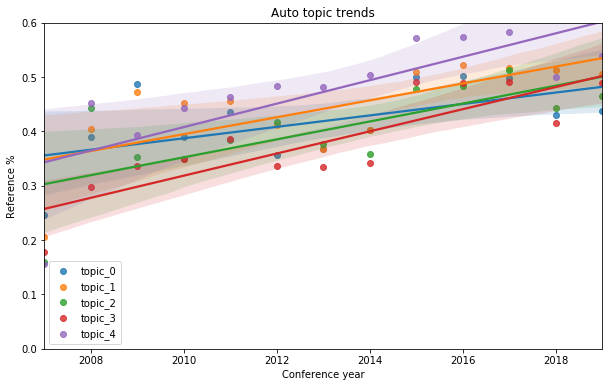

In [40]:
categories = ['topic_0','topic_1','topic_2','topic_3','topic_4']
labels = categories
regplot_time(topic_trends_av, 0.6, categories, labels, "Auto topic trends")

(<module 'matplotlib.pyplot' from 'C:\\Users\\Mike\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 <Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x24b7b3f8248>)

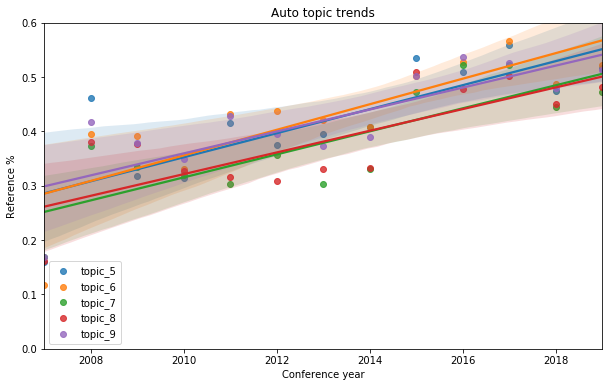

In [41]:
categories = ['topic_5','topic_6','topic_7','topic_8','topic_9']
labels = categories
regplot_time(topic_trends_av, 0.6, categories, labels, "Auto topic trends")

## Author analysis

In [42]:
#authors = df_cdflean.lead_author[df.year == 2019].unique()
#authors_df = pd.DataFrame(authors, columns = ['lead_author'])
#print(authors_df.shape)
#test = authors_df.sample(500)

In [43]:
#%%time
#citations = []
#for i in range(0,len(test)):
#    try:
#        search_query = scholarly.search_author(test.lead_author.iloc[i])
#        a = next(search_query)
#        citations_result = a.citedby
#        affiliations_result = a.affiliation
#        interests_result = a.interests         
#        citations.append({'author': test.lead_author.iloc[i], 'citations': citations_result, 'affiliation': affiliations_result, 'interests': interests_result})
#        print(i)
#    except:
#        pass

In [44]:
#academia_list = ['mit', 'berkeley', 'professor', 'university', 'student', 'institute', 'phd', 'fellow', 'centre', 'center' 'msc', 'ecole']
#FAANG_list = ['facebook', 'amazon', 'apple', 'netflix', 'google']

#citations_df['academia'] = citations_df.affiliation.str.contains('|'.join(academia_list))
#citations_df['faang'] = citations_df.affiliation.str.contains('|'.join(FAANG_list))

#a = citations_df.academia.sum()/len(citations_df)
#b = citations_df.faang.sum()/len(citations_df)

In [45]:
#print(len(citations))
#citations_df = pd.DataFrame(citations)
#citations_df = citations_df.sort_values('citations', ascending = False).reset_index()
#citations_df.affiliation = citations_df.affiliation.str.lower()
#citations_df.head()